# Cartpole Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    x & \dot{x} & \theta & \dot{\theta}
    \end{bmatrix}^T
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    F_{x}
    \end{bmatrix}^T
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0 & 0 & 0
    \end{bmatrix}^T
\end{equation*}
$$

**Note**: The force is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

In [4]:
import ilqr
from ilqr import iLQR
from ilqr.cost import QRCost, AutoDiffCost
from ilqr.dynamics import constrain
from ilqr.examples.cartpole import CartpoleDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.05
pole_length = 1.0
dynamics = CartpoleDynamics(dt, l=pole_length)

In [7]:
##QR COST
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0, 0.0, 0.0]))

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[0, 0] = 1.0
Q[1, 1] = Q[4, 4] = 0.0
Q[0, 2] = Q[2, 0] = pole_length
Q[2, 2] = Q[3, 3] = pole_length**2
R = 0.1 * np.eye(dynamics.action_size)

# Terminal state cost.
Q_terminal = 100 * np.eye(dynamics.state_size)

# Instantaneous control cost.
R = np.array([[0.1]])

cost1 = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
## AUTODIFF COST
def l(x, u, i):
    xdiff = x - torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0])
    cost = xdiff.matmul(torch.from_numpy(Q).matmul(xdiff)) + u.matmul(torch.from_numpy(R).matmul(u))
    return cost.reshape(())
def l_terminal(x, i):
    xdiff = x - torch.tensor([0.0, 0.0, 0.0, 1.0, 0.0])
    return xdiff.matmul(torch.from_numpy(Q_terminal).matmul(xdiff)).reshape(())
cost2 = AutoDiffCost(l, l_terminal, 5, 1)

In [9]:
N = 100
x0 = dynamics.augment_state(np.array([0.0, 0.0, np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))


In [10]:
ilqr = iLQR(dynamics, cost1, N)

In [11]:
J_hist = []
t0 = time.time()
xs, us = ilqr.fit(x0, us_init, n_iterations=500, on_iteration=on_iteration)
print("time", time.time() - t0)

iteration 0 accepted 799.9902746903902 [ 1.91151688e-03 -1.59579493e-03 -3.12193378e+00  5.87146336e-04]
iteration 1 accepted 799.8292265533257 [ 6.89843614e-04  4.40629847e-04 -3.10277069e+00 -7.11731037e-04]
iteration 2 accepted 799.3430295433075 [ 1.77204398e-03  6.73601746e-04 -3.06533462e+00 -3.40460345e-04]
iteration 3 accepted 797.4905391716559 [ 3.76217976e-03  1.07904766e-03 -2.99227769e+00  2.11880109e-04]
iteration 4 accepted 790.5183334684543 [ 8.45963025e-03  6.25605577e-04 -2.85022929e+00  3.84114995e-03]
iteration 5 accepted 765.8319046170744 [ 0.02407424 -0.00824286 -2.57900998  0.03393116]
iteration 6 accepted 737.2882692442608 [ 0.04851884  0.07791709 -2.11140772  0.46995935]
iteration 7 accepted 721.3102996452703 [ 0.00960657  0.0727815  -2.02991334  0.36238694]
iteration 8 accepted 709.5957561297906 [-0.02338808  0.06209173 -2.03851956  0.26432188]
iteration 9 accepted 695.9066852937523 [-0.00246673  0.05914518 -1.97446095  0.23641326]
iteration 10 accepted 694.2079

In [12]:
# Reduce the state to something more reasonable.
print(xs.shape)
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

(101, 5)


In [13]:
print(xs.shape)
t = np.arange(N + 1) * dt
x = xs[:, 0]
x_dot = xs[:, 1]
theta = np.unwrap(xs[:, 2])  # Makes for smoother plots.
theta_dot = xs[:, 3]

(101, 4)


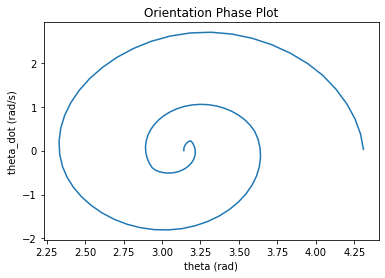

In [14]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Orientation Phase Plot")

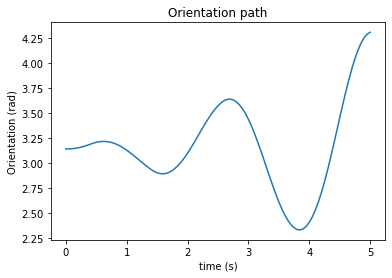

In [15]:
_ = plt.plot(t, theta)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Orientation (rad)")
_ = plt.title("Orientation path")

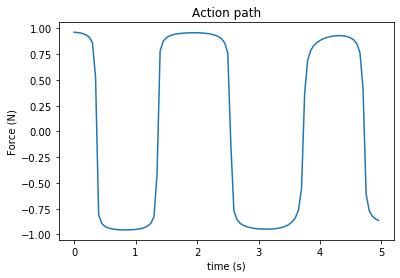

In [16]:
_ = plt.plot(t[:-1], us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

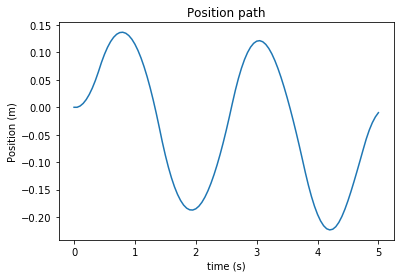

In [17]:
_ = plt.plot(t, x)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Position (m)")
_ = plt.title("Position path")

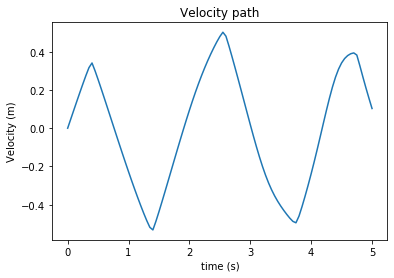

In [18]:
_ = plt.plot(t, x_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Velocity (m)")
_ = plt.title("Velocity path")

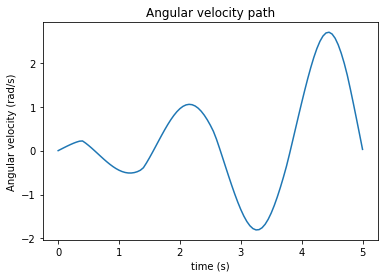

In [19]:
_ = plt.plot(t, theta_dot)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Angular velocity (rad/s)")
_ = plt.title("Angular velocity path")

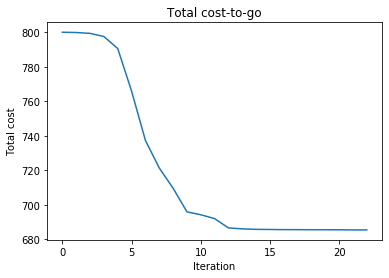

In [20]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")